# Прогноз оттока клиентов "Бета-Банка"
______

#### Данное исследование разделим на несколько частей.
______

### Часть 1. Изучение общей информации:
* [1. Изучение файла с данными, получение общей информации, загрузка библиотек.](#1-bullet)

### Часть 2. Подготовка данных:
* [1. Разделение исходных данных на обучающую, валидационную и тестовую выборки.](#2-bullet)

### Часть 3. Исследование задачи:
* [1. Исследование баланса классов.](#3-bullet)
* [2. Изучение моделей без учета дисбаланса классов и поиск наилучшей.](#4-bullet)

### Часть 4. Борьба с дисбалансом:
* [1. Придание объектам меньшего класса большего веса.](#5-bullet)
* [2. Увеличение выборок.](#6-bullet)
* [3. Уменьшение выборок.](#7-bullet)
* [4. Изменение порога классификации.](#8-bullet)

### Часть 5. Тестирование модели:
* [1. Метрика F1-мера.](#9-bullet)
* [2. Метрика AUC-ROC.](#10-bullet)

#### Описание данных:

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата
- Exited — факт ухода клиента

#### 1-bullet 
### Часть 1. Изучение общей информации:
#### 1. Изучение файла с данными, получение общей информации, загрузка библиотек.

In [1]:
# загружаем все необходимые для данного исследования библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# открываем файл с данными и получаем общую информацию по нему
data = pd.read_csv('/datasets/Churn.csv')
display(data.info())

# выведем на экран сумму дубликатов в таблице
display(data.duplicated().sum()) 

# выводим на экран первые пять строк для зрительного ознакомления
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None

0

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


### Вывод

- Открыли таблицу с данными и получили общую информацию: датасет состоит из 14 колонок и 10000 строк, имеет разные типы данных, в столбце наличия недвижимости имеются пропуски, дубликатов не имеется.
- Загрузили необходимые библиотеки, необходимые для данного исследования.

#### 2-bullet 
### Часть 2. Подготовка данных:
#### 1. Разделение исходных данных на обучающую, валидационную и тестовую выборки.

Заполним пустующие значения, стандартизируем численные признаки и преборазуем данные техникой OHE.

In [2]:
# заполним пустые значения в столбце недвижимости нулями
data['Tenure'] = data['Tenure'].fillna(0) 

# преобразуем данные техникой OHE
data_ohe = pd.get_dummies(data, drop_first=True)

# создадим спискок численных признаков, подлежащих стандартизации   
numeric = ['Balance', 'Age', 'EstimatedSalary']

# вызовем преобразователь масштаба и настоим его на признаках
scaler = StandardScaler()
scaler.fit(data[numeric]) 

# преобразуем признаки
data[numeric] = scaler.transform(data[numeric])

Разделим исходные данные на обучающую, валидационную и тестовую выборки

In [3]:
# сохраним в отдельных переменных признаки и целевой признак
features = data_ohe.drop(['Exited'], axis=1)
target = data_ohe['Exited']

# сохраним значение параметра random_state в переменной 
my_random_state = 123

# разделим на две выборки: на тестовую и для обучения с валидацией
features_train_valid, features_test, target_train_valid, target_test = (
    train_test_split(features, target, test_size=0.20, 
                     random_state=my_random_state))

# разделим на две выборки обучающую с валидационной выборку
features_train, features_valid, target_train, target_valid = (
    train_test_split(features_train_valid, target_train_valid, 
                     test_size=0.25, random_state=my_random_state))

### Вывод

- заполнили пропуски нулями.
- стандартизировали численные признаки.
- преобразовали данные техникой OHE.
- получили целевой признаки и признаки.
- сохранили значение random_state в переменной.
- разделели признаки и целевой признак на обучающую, валидационную и тестовую выборки в соотношении 3:1:1.

#### 3-bullet 
### Часть 3. Исследование задачи:
#### 1. Исследование баланса классов.

'Баланс классов:'

0    0.7963
1    0.2037
Name: Exited, dtype: float64

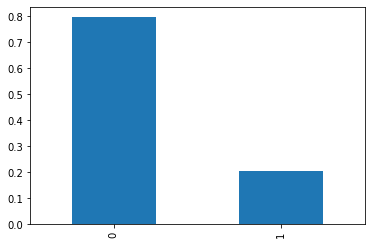

In [4]:
# рассчитаем количество уникальных значений в целевом признаке
class_frequency = data['Exited'].value_counts(normalize=0-1)
display('Баланс классов:', class_frequency)

# построим график уникальных значений для наглядности
class_frequency.plot(kind='bar')
plt.show()

- получили дисбаланс классов.
- далее построим модель решающего дерева и получим матрицу ошибок.

In [5]:
# обучим модель решающего дерева и получим предсказания
model = DecisionTreeClassifier(random_state=my_random_state)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)

# получим матрицу ошибок
print('Матирца ошибок:')
print(confusion_matrix(target_valid, predicted_valid))

# получим значения метрик accuracy, полноты, точности, F1-меры
print('Accuracy:', accuracy_score(predicted_valid, target_valid))
print('Полнота:', recall_score(target_valid, predicted_valid))
print('Точность:', precision_score(target_valid, predicted_valid))
print('F1-мера:', f1_score(target_valid, predicted_valid))

Матирца ошибок:
[[1432  148]
 [ 224  196]]
Accuracy: 0.814
Полнота: 0.4666666666666667
Точность: 0.5697674418604651
F1-мера: 0.5130890052356021


### Вывод
- исследование баланска классов показало, что в целевом признаке имеется выраженный дисбаланс в пользу отрицательного класса.
- матрица ошибок показывает, что модель почти одинако часто ошибается, когда находит истинно положительный и ложноположительный классы.
- получили значения метрик accuracy, полноты, точности, F1-меры.

#### 4-bullet 
### Часть 3. Исследование задачи:
#### 2. Изучение моделей без учета дисбаланса классов и поиск наилучшей модели.

- найдем наилучшее значение метрики F1-мера для модели решающее дерево, перебором гиперпараметра глубины, а также построим матрицу ошибок.

In [6]:
# создадим функцию, которая будет перебирать гиперпараметр 
# максимальной глубины дерева, возьмем от 1 до 50

best_model = None
best_result = 0
for depth in range(1, 51):
    # сохраним модель решающего дерева    
    model = DecisionTreeClassifier(random_state=my_random_state, 
                                   max_depth=depth) 
    model.fit(features_train, target_train) # обучим модель
    # получим предсказания модели по валидационной выборке
    predicted = model.predict(features_valid) 
    result = f1_score(target_valid, predicted) # получим качество модели
    # получим матрицу ошибок
    result_2 = confusion_matrix(target_valid, predicted)

    
    # найдем наилучшую модель
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        best_confusion_matrix = result_2
        
# выведем на экран наилучшее качество модели и глубину
print('F1-мера наилучшей модели на валидационной выборке:', best_result, 
      "Максимальная глубина:", best_depth)
print('Матирца ошибок:')
print(best_confusion_matrix)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-мера наилучшей модели на валидационной выборке: 0.5664739884393064 Максимальная глубина: 5
Матирца ошибок:
[[1504   76]
 [ 224  196]]


- получили наилучшее значение метрики 0.56 при максимальной глубине 5.
- количество ошибок при поиске положительного класса уменьшилось.

Далее найдем наилучшее значение метрики F1-мера для модели случайный лес, перебором гиперпараметров, а также построим матрицу ошибок.

In [7]:
# создадим функцию, которая будет перебирать гиперпараметры 
# количества деревьев от 10 до 60 с шагом в 10 и 
# максимальной глубины дерева от 1 до 60

best_model = None
best_result = 0
for est in range(10, 61, 10):
    for depth in range (1, 61):
        # сохраним модель случайный лес с искомыми гиперпараметрами
        model = RandomForestClassifier(random_state=my_random_state, 
                                       n_estimators=est, 
                                       max_depth=depth)
        model.fit(features_train, target_train) # обучим модель
        # получим предсказания по валидационной и обуч-й выборкам 
        predicted_valid = model.predict(features_valid) 
        # найдем значения метрики         
        result_1 = f1_score(target_valid, predicted_valid)
        # получим матрицу ошибок
        result_2 = confusion_matrix(target_valid, predicted_valid)
        
        # найдем лучшую модель
        if result_1 > best_result:
            best_model = model
            best_result = result_1
            best_est = est
            best_depth = depth
            best_confusion_matrix = result_2            
            
# выведем на экран качество лучшей модели, количество деревьев и глубина
print("F1-мера наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth) 
print('Матирца ошибок:')
print(best_confusion_matrix)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-sco

F1-мера наилучшей модели на валидационной выборке: 0.39783001808318263 Количество деревьев: 10 Максимальная глубина: 59
Матирца ошибок:
[[1557   23]
 [ 310  110]]


- получили наилучшее значение метрики 0.39 при количестве деревьев 10 и глубине 59.
- количество ошибок при поиске положительного класса уменьшилось, но сильно увеличилось количество ошибок при поиске отрицательного класса.

Далее построим модели логистической регрессии и найдем значение метрики F1-мера, а также построим матрицу ошибок.

In [8]:
# сохраним модель логистической регрессии
model = LogisticRegression(random_state=my_random_state, solver = 'liblinear') 
model.fit(features_train, target_train) # обучим модель 
predicted_valid = model.predict(features_valid) # получим предсказания
result_1 = f1_score(target_valid, predicted_valid)
result_2 = confusion_matrix(target_valid, predicted_valid)

# получим метрику и выведем на экран 
print("F1-мера модели на валидационной выборке:", result_1)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера модели на валидационной выборке: 0.0
Матирца ошибок:
[[1557   23]
 [ 310  110]]


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


получили плохой показатель метрики. Точность относительно высокая.

### Вывод

- лучшая модель для данной задачи без учета дисбаланса классов - решающее дерево с показателем F1 = 0,56.
- у модели случайный лес лучший показатель показателем F1 = 0,39.
- у модели логистической регрессии вообще показателем F1 = 0.
- Таким образом, модели без учета дисбаланса классов не пригодны, ввиду крайне низкой эффективности.

#### 5-bullet 
### Часть 4. Борьба с дисбалансом:
#### 1. Придание объектам меньшего класса большего веса.

придадим объектам положительного класса больший вес, воспользовавшись гиперпараметром class_weight='balanced'.

- найдем модель решающего дерева с наилучшим показателем F1-меры.

In [9]:
# создадим функцию, которая будет перебирать гиперпараметр 
# максимальной глубины дерева, возьмем от 1 до 50

best_model = None
best_result = 0
for depth in range(1, 51):
    # сохраним модель решающего дерева    
    model = DecisionTreeClassifier(random_state=my_random_state, 
                                        max_depth=depth, 
                                        class_weight='balanced') 
    model.fit(features_train, target_train) # обучим модель
    # получим предсказания модели по валидационной выборке
    predicted = model.predict(features_valid) 
    result = f1_score(target_valid, predicted) # получим качество модели
    # получим матрицу ошибок
    result_2 = confusion_matrix(target_valid, predicted)

    # найдем наилучшую модель
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        best_confusion_matrix = result_2
        
# выведем на экран наилучшее качество модели и глубину
print('F1-мера наилучшей модели на валидационной выборке:', best_result, 
      "Максимальная глубина:", best_depth)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера наилучшей модели на валидационной выборке: 0.5677546983184966 Максимальная глубина: 10
Матирца ошибок:
[[1276  304]
 [ 133  287]]


- получили аналогичный показатель F1 = 0.56, только при глубине 10.
- модель хорошо предсказывает отрицательный класс и сильно ошибается с предсказанием положительного класса.

далее поэкспериментируем с моделью случайный лес. найдем лучшую модель.

In [10]:
# создадим функцию, которая будет перебирать гиперпараметры 
# количества деревьев от 10 до 60 с шагом в 10 и 
# максимальной глубины дерева от 1 до 60

best_model = None
best_result = 0
for est in range(10, 61, 10):
    for depth in range (1, 61):
        # сохраним модель случайный лес с искомыми гиперпараметрами
        model = RandomForestClassifier(random_state=my_random_state, 
                                       n_estimators=est, 
                                       max_depth=depth, 
                                       class_weight='balanced')
        model.fit(features_train, target_train) # обучим модель
        # получим предсказания по валидационной и обуч-й выборкам 
        predicted_valid = model.predict(features_valid) 
        result = f1_score(target_valid, predicted_valid)
        # получим матрицу ошибок
        result_2 = confusion_matrix(target_valid, predicted_valid)
    
        # найдем лучшую модель
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
            best_confusion_matrix = result_2
            
# выведем на экран качество лучшей модели, количество деревьев и глубина
print("F1-мера наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth) 
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера наилучшей модели на валидационной выборке: 0.5732009925558312 Количество деревьев: 40 Максимальная глубина: 35
Матирца ошибок:
[[1425  155]
 [ 189  231]]


- искомая метрика значительно увеличилась, значение метрики F1 = 0,57 при количестве деревьев 40 и глубине 35
- вместе с этим увеличилась точность предсказаний положительного класси и ухудшилась точность предсказаний отрицательного класса.

построим модель логистической регрессии.

In [11]:
# сохраним модель логистической регрессии
model = LogisticRegression(random_state=my_random_state, 
                           class_weight='balanced', 
                           solver = 'liblinear') 
model.fit(features_train, target_train) # обучим модель 
predicted_valid = model.predict(features_valid) # получим предсказания
result_1 = f1_score(target_valid, predicted_valid)
result_2 = confusion_matrix(target_valid, predicted_valid)

# получим метрику и выведем на экран 
print("F1-мера модели на валидационной выборке:", result_1)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера модели на валидационной выборке: 0.47725321888412015
Матирца ошибок:
[[1425  155]
 [ 189  231]]


- получили значительно лучший показатель метрики F1 = 0.47, матрица ошибок показывает, что модель чаще ошибается, чем верно находит положительный класс.

### Вывод

- пришли к выводу, что придание большего веса объектам меньшего класса положительно сказалось на работе моделей случайный лес и логистическая регрессия.
- на модель решающее дерево придание большего веса объектам меньшего класса практически не повлияло.

#### 6-bullet 
### Часть 4. Борьба с дисбалансом:
#### 2. Увеличение выборок.

далее попробуем пойти путем увеличения выборки: увеличим и перемешаем обучающую выборку.

In [12]:
# объявим функцию, которая будет принимать на вход
# признаки, целевой признак и количество повторений
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # увеличим количество объектов признаков и целевого признака
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем объекты
    features_upsampled, target_upsampled = shuffle(features_upsampled, 
                                                   target_upsampled, 
                                                   random_state=my_random_state)
    
    return features_upsampled, target_upsampled

# применим функцию
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

теперь обучим модель решающего дерева на увеличенной выборке и найдем лучшую.

In [13]:
# создадим функцию, которая будет перебирать гиперпараметр 
# максимальной глубины дерева, возьмем от 1 до 60
best_model = None
best_result = 0
for depth in range(1, 61):
    # сохраним модель решающего дерева    
    model = DecisionTreeClassifier(random_state=my_random_state, 
                                        max_depth=depth, 
                                        class_weight='balanced') 
    # обучим моедль и получим предсказания
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid) 
    result = f1_score(target_valid, predicted_valid) # получим метрику
    
    # получим матрицу ошибок
    result_2 = confusion_matrix(target_valid, predicted_valid)

    # найдем наилучшую модель
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        best_confusion_matrix = result_2
        
# выведем на экран наилучшее качество модели и глубину
print('F1-мера наилучшей модели на валидационной выборке:', best_result, 
      "Максимальная глубина:", best_depth)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера наилучшей модели на валидационной выборке: 0.56973293768546 Максимальная глубина: 10
Матирца ошибок:
[[1277  303]
 [ 132  288]]


- получили практически идентичный показатель F1-меры.
- точность предсказаний осталась также на прежнем уровне.

построим и обучим модель случайного леса на увеличенной выборке и найдем лучшую.

In [14]:
# создадим функцию, которая будет перебирать гиперпараметры 
# количества деревьев от 10 до 60 с шагом в 10 и 
# максимальной глубины дерева от 1 до 60

best_model = None
best_result = 0
for est in range(10, 61, 10):
    for depth in range (1, 61):
        # сохраним модель случайный лес с искомыми гиперпараметрами
        model = RandomForestClassifier(random_state=my_random_state, 
                                       n_estimators=est, 
                                       max_depth=depth, 
                                       class_weight='balanced')
        model.fit(features_upsampled, target_upsampled) # обучим модель
        # получим предсказания по валидационной и обуч-й выборкам 
        predicted_valid = model.predict(features_valid) 
        result = f1_score(target_valid, predicted_valid)
        # получим матрицу ошибок
        result_2 = confusion_matrix(target_valid, predicted_valid)
    
        # найдем лучшую модель
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
            best_confusion_matrix = result_2
            
# выведем на экран качество лучшей модели, количество деревьев и глубина
print("F1-мера наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth) 
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера наилучшей модели на валидационной выборке: 0.5948051948051948 Количество деревьев: 40 Максимальная глубина: 60
Матирца ошибок:
[[1459  121]
 [ 191  229]]


- получили наилучшее значение метрики F1-мера = 0.59 при количестве деревьев 40 и глубине 60. 
- при этом матрица ошибок практически аналогичная.
- подтвердилось правило: чем больше данных, тем лучше.

построим и обучим модель логистической регрессии на обучающей выборке.

In [15]:
# сохраним модель логистической регрессии
model = LogisticRegression(random_state=my_random_state, 
                           class_weight='balanced', 
                           solver = 'liblinear') 
model.fit(features_upsampled, target_upsampled) # обучим модель 
predicted_valid = model.predict(features_valid) # получим предсказания
result_1 = f1_score(target_valid, predicted_valid)
result_2 = confusion_matrix(target_valid, predicted_valid)

# получим метрику и выведем на экран 
print("F1-мера модели на валидационной выборке:", result_1)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера модели на валидационной выборке: 0.47390932420872545
Матирца ошибок:
[[1459  121]
 [ 191  229]]


- значение метрики практически не изменилось, показатели матрицы ошибок тоже.

### Вывод

- пришли к выводу, что увеличение выборки положительно сказалось только на модели случайный лес, где значение метрики F1 достигло 0.58
- при этом на модели решающее дерево и логистическую регрессию увеличение выборок практически никак не повлияло.

#### 7-bullet 
### Часть 4. Борьба с дисбалансом:
#### 3. Уменьшение выборок.

Попробуем уменьшить обучающую выборку.

In [16]:
# объявим функцию, которая будет принимать на вход
# признаки, целевой признак и количество повторений
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # уменьшим количество объектов признаков и целевого признака
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    # перемешаем объекты
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# применим функцию
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.2)

обучим модель решающего дерева на уменьшенной выборке и найдем лучшую.

In [17]:
# создадим функцию, которая будет перебирать гиперпараметр 
# максимальной глубины дерева, возьмем от 1 до 60
best_model = None
best_result = 0
for depth in range(1, 61):
    # сохраним модель решающего дерева    
    model = DecisionTreeClassifier(random_state=my_random_state, 
                                        max_depth=depth, 
                                        class_weight='balanced') 
    # обучим моедль и получим предсказания
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid) 
    result = f1_score(target_valid, predicted_valid) # получим метрику
    
    # получим матрицу ошибок
    result_2 = confusion_matrix(target_valid, predicted_valid)

    # найдем наилучшую модель
    if result > best_result:
        best_model = model
        best_result = result
        best_depth = depth
        best_confusion_matrix = result_2
        
# выведем на экран наилучшее качество модели и глубину
print('F1-мера наилучшей модели на валидационной выборке:', best_result, 
      "Максимальная глубина:", best_depth)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера наилучшей модели на валидационной выборке: 0.5526075022872827 Максимальная глубина: 7
Матирца ошибок:
[[1209  371]
 [ 118  302]]


- показатель метрики ухудшился, значит этот метод не подходит.

обучим модель случайного леса и найдем лучшую.

In [18]:
# создадим функцию, которая будет перебирать гиперпараметры 
# количества деревьев от 10 до 60 с шагом в 10 и 
# максимальной глубины дерева от 1 до 60
best_model = None
best_result = 0
for est in range(10, 61, 10):
    for depth in range (1, 61):
        # сохраним модель случайный лес с искомыми гиперпараметрами
        model = RandomForestClassifier(random_state=my_random_state, 
                                       n_estimators=est, 
                                       max_depth=depth, 
                                       class_weight='balanced')
        model.fit(features_downsampled, target_downsampled) # обучим модель
        # получим предсказания по валидационной и обуч-й выборкам 
        predicted_valid = model.predict(features_valid) 
        result = f1_score(target_valid, predicted_valid)
        # получим матрицу ошибок
        result_2 = confusion_matrix(target_valid, predicted_valid)
    
        # найдем лучшую модель
        if result > best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth
            best_confusion_matrix = result_2
            
# выведем на экран качество лучшей модели, количество деревьев и глубина
print("F1-мера наилучшей модели на валидационной выборке:", best_result, 
      "Количество деревьев:", best_est, "Максимальная глубина:", best_depth) 
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера наилучшей модели на валидационной выборке: 0.5476635514018692 Количество деревьев: 40 Максимальная глубина: 19
Матирца ошибок:
[[1223  357]
 [ 127  293]]


- показатель метрики ухудшился, значил метод уменьшения выборок не подходит.

обучим модель логистической регрессии.

In [19]:
# сохраним модель логистической регрессии
model = LogisticRegression(random_state=my_random_state, 
                           class_weight='balanced', 
                           solver = 'liblinear') 
model.fit(features_downsampled, target_downsampled) # обучим модель 
predicted_valid = model.predict(features_valid) # получим предсказания
result_1 = f1_score(target_valid, predicted_valid)
result_2 = confusion_matrix(target_valid, predicted_valid)

# получим метрику и выведем на экран 
print("F1-мера модели на валидационной выборке:", result_1)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера модели на валидационной выборке: 0.4802744425385935
Матирца ошибок:
[[1223  357]
 [ 127  293]]


- показатель метрики незначительно увеличился, но ухудшились правильные прогнозы положительно класса, также незначительно ухудшились правильные прогнозы отрицательного класса.

### Вывод

- пришли к выводу, что уменьшение выборок не подходит для решения нашей задачи. Даже модель логистической регрессии, демонстрирующая незначительное улучшение показателя F1-меры, сильно теряет в точности, что также не приемлемо.

#### 8-bullet 
### Часть 4. Борьба с дисбалансом:
#### 4. Изменение порога классификации.

далее поробуем найти значения метрики, изменяя порог классификации.

построим и найдем наилучшую модель случайного леса.

In [20]:
# создадим функцию, которая будет перебирать гиперпараметр 
# максимальной глубины дерева, возьмем от 1 до 60 и аналогичной глубиной
best_model = None
best_result = 0
for est in range(10, 61, 10):
    for depth in range (1, 61): 
        # сохраним модель случайный лес с искомыми гиперпараметрами
        model = RandomForestClassifier(random_state=my_random_state, 
                                       n_estimators=est, 
                                       max_depth=depth, 
                                       class_weight='balanced')
        # обучим моедль и получим предсказания
        model.fit(features_upsampled, target_upsampled)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1] 
        for threshold in np.arange(0, 0.2, 0.05):
            predicted_valid = probabilities_one_valid > threshold
            result = f1_score(target_valid, predicted_valid)         
            # получим матрицу ошибок
            result_2 = confusion_matrix(target_valid, predicted_valid)

            # найдем наилучшую модель
            if result > best_result:
                best_model = model
                best_result = result
                best_est = est
                best_depth = depth
                best_confusion_matrix = result_2
                best_threshold = threshold
        
# выведем на экран наилучшее качество модели и глубину
print('F1-мера наилучшей модели:', best_result, 
      "Максимальная глубина:", best_depth, 'Количество деревьев:', best_est, 
      'Порог', threshold)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера наилучшей модели: 0.3940269749518304 Максимальная глубина: 57 Количество деревьев: 10 Порог 0.15000000000000002
Матирца ошибок:
[[ 333 1247]
 [  11  409]]


- перебор порога классификации не помог улучшить модель, поэтому не будем его использовать.

построим и найдем наилучшую модель решающего дерева.

In [21]:
# создадим функцию, которая будет перебирать гиперпараметр 
# максимальной глубины дерева, возьмем от 1 до 60
best_model = None
best_result = 0
model_tree = DecisionTreeClassifier(random_state=my_random_state, 
                                    max_depth=10, class_weight='balanced')
                                   
for depth in range(1, 61):
    # сохраним модель решающего дерева    
    model = DecisionTreeClassifier(random_state=my_random_state, 
                                   max_depth=depth, 
                                   class_weight='balanced') 
    # обучим моедль и получим предсказания
    model.fit(features_upsampled, target_upsampled)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1] 
    for threshold in np.arange(0, 0.2, 0.05):
        predicted_valid = probabilities_one_valid > threshold
        result = f1_score(target_valid, predicted_valid)         
        # получим матрицу ошибок
        result_2 = confusion_matrix(target_valid, predicted_valid)
        # найдем наилучшую модель
        if result > best_result:
            best_model = model
            best_result = result
            best_depth = depth
            best_confusion_matrix = result_2
            best_threshold = threshold

            # выведем на экран наилучшее качество модели и глубину
print('F1-мера наилучшей модели:', best_result, 
      "Максимальная глубина:", best_depth, 'Порог', threshold)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера наилучшей модели: 0.541617819460727 Максимальная глубина: 20 Порог 0.15000000000000002
Матирца ошибок:
[[1378  202]
 [ 189  231]]


- перебор порога классификации не помог улучшить модель, поэтому не будем его использовать.

построим модель логистической регрессии.

In [22]:
best_model = None
best_result = 0

# сохраним модель логистической регрессии
model = LogisticRegression(random_state=my_random_state, 
                           class_weight='balanced', 
                           solver = 'liblinear') 
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    precision = precision_score(target_valid, predicted_valid)
    recall = recall_score(target_valid, predicted_valid)
    result = f1_score(target_valid, predicted_valid)  
    # получим матрицу ошибок
    result_2 = confusion_matrix(target_valid, predicted_valid)
    
    if result > best_result:
            best_model = model
            best_result = result
            best_confusion_matrix = result_2
            best_threshold = threshold
    
print('F1-мера наилучшей модели:', 
      best_result, 'Порог', threshold)
print('Матирца ошибок:')
print(best_confusion_matrix)

F1-мера наилучшей модели: 0.39289239881539983 Порог 0.29
Матирца ошибок:
[[ 372 1208]
 [  22  398]]


- перебор порога классификации не помог улучшить модель, поэтому не будем его использовать.

### Вывод

- изменение порога классификации не помогло улучшить ни одну модель.

#### 9-bullet 
### Часть 5. Тестирование модели:
#### 1. Метрика F1-мера.

увеличим обучающую с валидационной выборки для последующего обучения моделей.

In [23]:
# объявим функцию, которая будет принимать на вход
# признаки, целевой признак и количество повторений
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    # увеличим количество объектов признаков и целевого признака
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    # перемешаем объекты
    features_upsampled, target_upsampled = shuffle(features_upsampled, 
                                                   target_upsampled, 
                                                   random_state=my_random_state)
    
    return features_upsampled, target_upsampled

# применим функцию
features_upsampled, target_upsampled = upsample(features_train_valid, target_train_valid, 10)

обучим модель решающего дерева на увеличенной выборке и рассчитаем значение F1-меры по тестовой выборке.

In [24]:
# постороим модель решающего дерева, придав классам
# равное значение                        
model = DecisionTreeClassifier(random_state=my_random_state, 
                               max_depth=10, class_weight='balanced')
# обучим моедль и получим предсказания
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
result_2 = confusion_matrix(target_test, predicted_test)

# выведем на экран значение метрики
print("F1-мера модели:", f1_score(target_test, predicted_test))
print('Матирца ошибок:')
print(result_2)

F1-мера модели: 0.5656565656565657
Матирца ошибок:
[[1290  296]
 [ 134  280]]


обучим модель случайный лес и рассчитаем значение метрики по тестовой выборке.

In [25]:
# сохраним модель случайный лес с искомыми гиперпараметрами
model = RandomForestClassifier(random_state=my_random_state, 
                               n_estimators=40, 
                               max_depth=60, 
                               class_weight='balanced')
model.fit(features_upsampled, target_upsampled) # обучим модель
# получим предсказания по валидационной и обуч-й выборкам 
predicted_test = model.predict(features_test) 
result = f1_score(target_test, predicted_test)
# получим матрицу ошибок
result_2 = confusion_matrix(target_test, predicted_test)
         
            
# выведем на экран качество лучшей модели, количество деревьев и глубина
print("F1-мера модели на тестовой выборке:", result) 
print('Матирца ошибок:')
print(result_2)

F1-мера модели на тестовой выборке: 0.6121437422552665
Матирца ошибок:
[[1440  146]
 [ 167  247]]


построим модель логистической регрессии и рассчитаем значение метрики по тестовой выборке.

In [26]:
# сохраним модель логистической регрессии
model = LogisticRegression(random_state=my_random_state, 
                           class_weight='balanced', 
                           solver = 'liblinear') 
model.fit(features_upsampled, target_upsampled) # обучим модель 
# получим предсказания по валидационной и обуч-й выборкам 
predicted_test = model.predict(features_test) 
result = f1_score(target_test, predicted_test)
# получим матрицу ошибок
result_2 = confusion_matrix(target_test, predicted_test)

# выведем на экран качество лучшей модели, количество деревьев и глубина
print("F1-мера модели на тестовой выборке:", result) 
print('Матирца ошибок:')
print(result_2)

F1-мера модели на тестовой выборке: 0.4809688581314879
Матирца ошибок:
[[1122  464]
 [ 136  278]]


### Вывод

#### 10-bullet 
### Часть 5. Тестирование модели:
#### 2. Метрика AUC-ROC.

построим график ROC-кривой и рассчитаем метрику для модели решающее дерево.

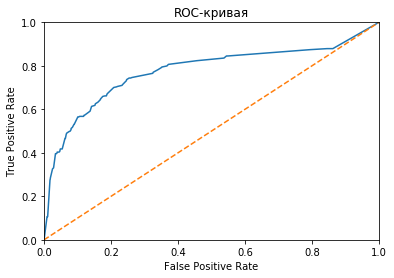

auc_roc: 0.7752671320917934


In [27]:
model = DecisionTreeClassifier(random_state=my_random_state, 
                               max_depth=10, class_weight='balanced')
# обучим моедль и получим предсказания
model.fit(features_train_valid, target_train_valid)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('auc_roc:', auc_roc)

- получили значение auc_roc: 0.77. оно далеко от 1, как и F1-мера меньше 0.6.
- это говорит о том, что модель плохо работает.

построим график ROC-кривой и рассчитаем метрику для модели случайный лес.

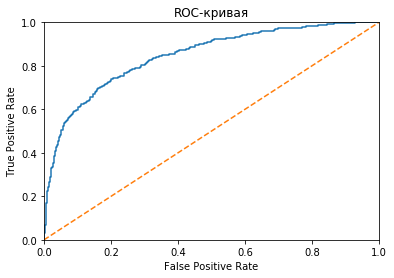

auc_roc: 0.846187351889419


In [28]:
# сохраним модель случайный лес с искомыми гиперпараметрами
model = RandomForestClassifier(random_state=my_random_state, 
                               n_estimators=40, 
                               max_depth=60, 
                               class_weight='balanced')
# обучим моедль и получим предсказания
model.fit(features_train_valid, target_train_valid)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)# < напишите код здесь >

print('auc_roc:', auc_roc)

- получили значение auc_roc: 0.84. F1-меру чуть больше 0.6.
- в нашей задаче это наиболее работоспобосная модель, хоть и далекая от идеала.

построим график ROC-кривой и рассчитаем метрику для модели логистическая регрессия.

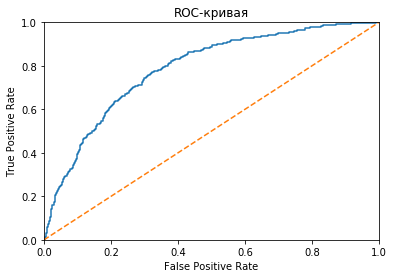

auc_roc: 0.7855648153224775


In [29]:
# сохраним модель логистической регрессии
model = LogisticRegression(random_state=my_random_state, 
                           class_weight='balanced', 
                           solver = 'liblinear') 
# обучим моедль и получим предсказания
model.fit(features_train_valid, target_train_valid)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
plt.show()

auc_roc = roc_auc_score(target_test, probabilities_one_test)# < напишите код здесь >

print('auc_roc:', auc_roc)

- получили значение auc_roc: 0.78. оно далеко от 1, как и F1-мера меньше 0.6.
- вновь приходим к выводу, что модель плохо работает.

### Вывод

- пришли к выводу, что между метрикой F1-мера и auc_roc имеется зависимость.
- о работоспособности модели могут свидетельствовать только высокие показатели метрики F1-мера и auc_roc.
- удалось достичь F1-меры более 0.6 только на модели случайный лес со следующими параметрами: количество деревьев - 40, глубина - 60, меньшему классу придали больший вес, порог классификации не меняли, обучали модель на увеличенной выборке.
